# Amazon Bedrock AgentCore Observability with CrewAI Agent hosted outside of AgentCore Runtime

This notebook demonstrates how to use setup observability for a [CrewAI](https://www.crewai.com/) agent hosted outside of Amazon Bedrock AgentCore Runtime. Once you have completed the setup, you will be able to view the internal decision making process of CrewAI agent in GenAI Observability dashboard in Amazon CloudWatch.

We will build a single agent with access to a web search tool that helps plan your travels.


## What you'll learn
- How to set up CrewAI with Amazon OpenTelemetry Python Instrumentation
- How to visualize and analyze agent traces in Amazon CloudWatch GenAI Observability



## Prerequisites
- Enable transaction search on Amazon CloudWatch. First-time users must enable CloudWatch Transaction Search to view Bedrock AgentCore spans and traces. To enable transaction search, please refer to the our [documentation](https://docs.aws.amazon.com/AmazonCloudWatch/latest/monitoring/Enable-TransactionSearch.html).
- Log group and Log stream configured on Amazon Cloudwatch to be added to the environment variables.
- AWS account with Amazon Bedrock Model access to Claude Haiku with Model ID: anthropic.claude-3-haiku-20240307-v1:0
- AWS credentials configured using `aws configure` 
- .env file updated with environment variables. An example is provided in `.env.example`

## 1. Setup and Installation

First, let's install the required dependencies. Please check that `aws-opentelemetry-distro` in your requirements.txt file.  

In [ ]:
#!pip install -r requirements.txt

## 2. Environment Configuration
To enable observability for your CrewAI agent and send telemetry data to Amazon CloudWatch, you'll need to configure the following environment variables. We use a `.env` file to manage these settings securely, keeping sensitive AWS credentials separate from your code while making it easy to switch between different environments.

Create a `.env` file with your AWS credentials and configuration. Use `CrewAI/.env.example` as a template.

If you are using an existing `log group` and corresponding `log stream`, please add that to your environment variable. 

Else, you would need to **create** a log group and stream in Cloudwatch before you set that as an environment variable, example names are provided.

Required Environment Variables:

| Variable | Value | Purpose |
|----------|-------|---------|
| `OTEL_PYTHON_DISTRO` | `aws_distro` | Use AWS Distro for OpenTelemetry (ADOT) |
| `OTEL_PYTHON_CONFIGURATOR` | `aws_configurator` | Set AWS configurator for ADOT SDK |
| `OTEL_EXPORTER_OTLP_PROTOCOL` | `http/protobuf` | Configure export protocol |
| `OTEL_EXPORTER_OTLP_LOGS_HEADERS` | `x-aws-log-group=<YOUR-LOG-GROUP>,x-aws-log-stream=<YOUR-LOG-STREAM>,x-aws-metric-namespace=<YOUR-NAMESPACE>` | Direct logs to CloudWatch groups |
| `OTEL_RESOURCE_ATTRIBUTES` | `service.name=<YOUR-AGENT-NAME>` | Identify your agent in observability data |
| `AGENT_OBSERVABILITY_ENABLED` | `true` | Activate ADOT pipeline |
| `AWS_REGION` | `<YOUR-REGION>` | AWS Region |

## 3. Load Environment Variables

Let's load the environment variables from the `.env` file:

In [ ]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Display the OTEL-related environment variables
otel_vars = [
    "OTEL_PYTHON_DISTRO",
    "OTEL_PYTHON_CONFIGURATOR",
    "OTEL_EXPORTER_OTLP_PROTOCOL",
    "OTEL_EXPORTER_OTLP_LOGS_HEADERS",
    "OTEL_RESOURCE_ATTRIBUTES",
    "AGENT_OBSERVABILITY_ENABLED",
    "OTEL_TRACES_EXPORTER"
]

print("OpenTelemetry Configuration:")
for var in otel_vars:
    value = os.getenv(var)
    if value:
        print(f"{var}={value}")

## 4. Create a CrewAI Agent in a python file

Crew AI Travel Agent implementation is provided in `CrewAI_Travel_Agent.py`. It is a Travel Agent set up with the model from Amazon Bedrock. The AWS OpenTelemetry distro will automatically handle tracer provider setup when using `opentelemetry-instrument` command. Disable CrewAI's built-in telemetry to avoid conflicts.


The agent is a simple travel recommendation agent that:

- Creates a single AI agent called "Travel Destination Researcher" using AWS Bedrock's Claude Haiku model
- Assigns this agent the goal of finding destinations that match user preferences
- Gives the agent a task to research and recommend travel destinations specifically for someone interested in "cowboy vibes, rodeos, and museums"
- Runs the agent and returns a list of recommended destinations with brief descriptions

The Agent is Configured with the following: 

- A specific role and goal to guide its behavior : Travel Destination Researcher
- A backstory that is the Agent’s experience and perspective
- Verbose mode to show detailed output during execution
- A maximum of 3 iterations to prevent excessive API calls
- Amazon Bedrock's Claude Haiku model as it's Large Language Model.
- Tool to search the web for current information about travel destinations, attractions, and events.

The `crew` is created and executed using `crew.kickoff` in the file.


In [ ]:
%%writefile crewai_travel_agent.py
import os
# Disable CrewAI's built-in telemetry to avoid conflicts
os.environ["CREWAI_DISABLE_TELEMETRY"] = "true"

###########################
#### Agent Code below: ####
###########################

from crewai import Agent, Task, Crew, LLM
from crewai.tools import tool
from duckduckgo_search import DDGS
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@tool("web_search")
def web_search(query: str) -> str:
    """Search the web for current information about travel destinations, attractions, and events."""
    try:
        ddgs = DDGS()
        results = ddgs.text(query, max_results=5)
        
        formatted_results = []
        for i, result in enumerate(results, 1):
            formatted_results.append(
                f"{i}. {result.get('title', 'No title')}\n"
                f"   {result.get('body', 'No summary')}\n"
                f"   Source: {result.get('href', 'No URL')}\n"
            )
        
        return "\n".join(formatted_results) if formatted_results else "No results found."
        
    except Exception as e:
        return f"Search error: {str(e)}"

def get_llm():
    model_id = os.getenv("BEDROCK_MODEL_ID", "anthropic.claude-3-haiku-20240307-v1:0")
    region = os.getenv("AWS_DEFAULT_REGION", "us-west-2")
    
    try:
        llm = LLM(
            model=f"bedrock/{model_id}",
            temperature=0.0,
            max_tokens=512,
            aws_region_name=region
        )
        logger.info(f"Successfully initialized Bedrock LLM with model: {model_id} in region: {region}")
        return llm
    except Exception as e:
        logger.error(f"Failed to initialize Bedrock LLM: {str(e)}")
        logger.error("Please ensure you have proper AWS credentials configured and access to the Bedrock model")
        raise

llm = get_llm()

travel_agent = Agent(
    role='Travel Destination Researcher',
    goal='Find dream destinations matching user preferences using web search for current information',
    backstory="You are an experienced travel agent specializing in personalized travel recommendations with access to real-time web information.",
    verbose=True,
    allow_delegation=False,
    llm=llm,
    max_iter=3,
    tools=[web_search]
)

task = Task(
    description="Research and recommend suitable travel destinations for someone looking for cowboy vibes, rodeos, and museums in New York city. Use web search to find current information about venues, events, and attractions.",
    expected_output="A comprehensive list of recommended destinations with current information, brief descriptions, and practical travel details.",
    agent=travel_agent
)

crew = Crew(
    agents=[travel_agent],
    tasks=[task],
    verbose=True
)

result = crew.kickoff()
print("Result:", result)

## 5. AWS OpenTelemetry Python Distro

Now that your environment is configured, let's understand how the observability happens. The [AWS OpenTelemetry Python Distro](https://pypi.org/project/aws-opentelemetry-distro/) automatically instruments your CrewAI agent to capture telemetry data without requiring code changes.

This distribution provides:
- **Auto-instrumentation** for your CrewAI Agent hosted outside of AgentCore Runtime (i.e. EC2, Lambda etc..)
- **AWS-optimized configuration** for seamless CloudWatch integration  

### Running Your Instrumented Agent

To capture traces from your CrewAI agent, use the `opentelemetry-instrument` command instead of running Python directly. This automatically applies instrumentation using the environment variables from your `.env` file:

```bash
opentelemetry-instrument python crewai_travel_agent.py
```

This command will:

- Load your OTEL configuration from the .env file
- Automatically instrument CrewAI, Amazon Bedrock calls, agent tool and other requests made by agent
- Send trace and logs to Amazon CloudWatch
- Enable you to visualize the agent's decision-making process in the GenAI Observability dashboard in Amazon CloudWatch.

In [ ]:
!opentelemetry-instrument python crewai_travel_agent.py

## 6. Adding Session Tracking

To correlate traces across multiple agent runs, you can associate a session ID with your telemetry data using OpenTelemetry baggage:

```python
from opentelemetry import baggage, context
ctx = baggage.set_baggage("session.id", session_id)
```

Run the session-enabled version:
```bash
opentelemetry-instrument python crewai_travel_agent_with_session.py --session-id "user-session-123"
```

## 7. Custom Metadata for Analysis
Add custom attributes to enable filtering, offline evaluations, and performance analysis. You would need to modify your agent code to accept additional parameters:
```python
ctx = baggage.set_baggage("user.type", "premium")
ctx = baggage.set_baggage("experiment.id", "travel-agent-v2")
ctx = baggage.set_baggage("conversation.topic", "business-travel")
```

Example commands with custom metadata:

```bash
# A/B testing different experiments
opentelemetry-instrument python agent.py --session-id "session-123" --experiment-id "model-a"
opentelemetry-instrument python agent.py --session-id "session-124" --experiment-id "model-b"

# Tracking different user types
opentelemetry-instrument python agent.py --session-id "session-125" --user-type "premium"
opentelemetry-instrument python agent.py --session-id "session-126" --user-type "free"

# Offline evaluation runs
opentelemetry-instrument python agent.py --session-id "eval-001" --dataset "golden-set-v1"
```
These attributes appear in CloudWatch traces for advanced filtering and analysis.

In [ ]:
%%writefile crewai_travel_agent_with_session.py
import os
import logging
import sys
import argparse
from opentelemetry import baggage, context

# Disable CrewAI's built-in telemetry to avoid conflicts
os.environ["CREWAI_DISABLE_TELEMETRY"] = "true"

def parse_arguments():
    parser = argparse.ArgumentParser(description='CrewAI Travel Agent with Session Tracking')
    parser.add_argument('--session-id', 
                       type=str, 
                       required=True,
                       help='Session ID to associate with this agent run')
    return parser.parse_args()

def set_session_context(session_id):
    """Set the session ID in OpenTelemetry baggage for trace correlation"""
    ctx = baggage.set_baggage("session.id", session_id)
    token = context.attach(ctx)
    logging.info(f"Session ID '{session_id}' attached to telemetry context")
    return token

###########################
#### Agent Code below: ####
###########################

from crewai import Agent, Task, Crew, LLM
from crewai.tools import tool
from duckduckgo_search import DDGS

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@tool("web_search")
def web_search(query: str) -> str:
    """Search the web for current information about travel destinations, attractions, and events."""
    try:
        ddgs = DDGS()
        results = ddgs.text(query, max_results=5)
        
        formatted_results = []
        for i, result in enumerate(results, 1):
            formatted_results.append(
                f"{i}. {result.get('title', 'No title')}\n"
                f"   {result.get('body', 'No summary')}\n"
                f"   Source: {result.get('href', 'No URL')}\n"
            )
        
        return "\n".join(formatted_results) if formatted_results else "No results found."
        
    except Exception as e:
        return f"Search error: {str(e)}"

def get_llm():
    model_id = os.getenv("BEDROCK_MODEL_ID", "anthropic.claude-3-haiku-20240307-v1:0")
    region = os.getenv("AWS_DEFAULT_REGION", "us-west-2")
    
    try:
        llm = LLM(
            model=f"bedrock/{model_id}",
            temperature=0.7,
            max_tokens=512,
            aws_region_name=region
        )
        logger.info(f"Successfully initialized Bedrock LLM with model: {model_id} in region: {region}")
        return llm
    except Exception as e:
        logger.error(f"Failed to initialize Bedrock LLM: {str(e)}")
        logger.error("Please ensure you have proper AWS credentials configured and access to the Bedrock model")
        raise

def main():
    # Parse command line arguments
    args = parse_arguments()
    
    # Set session context for telemetry
    context_token = set_session_context(args.session_id)
    
    try:
        # Initialize LLM
        llm = get_llm()

        # Create travel agent
        travel_agent = Agent(
            role='Travel Destination Researcher',
            goal='Find dream destinations matching user preferences using web search for current information',
            backstory="You are an experienced travel agent specializing in personalized travel recommendations with access to real-time web information.",
            verbose=True,
            allow_delegation=False,
            llm=llm,
            max_iter=3,
            tools=[web_search]
        )

        # Create task
        task = Task(
            description="Research and recommend suitable travel destinations for someone looking for cowboy vibes, rodeos, and museums in New York city. Use web search to find current information about venues, events, and attractions.",
            expected_output="A comprehensive list of recommended destinations with current information, brief descriptions, and practical travel details.",
            agent=travel_agent
        )

        # Create and run crew
        crew = Crew(
            agents=[travel_agent],
            tasks=[task],
            verbose=True
        )

        result = crew.kickoff()
        print("Result:", result)
        
    finally:
        # Detach context when done
        context.detach(context_token)
        logger.info(f"Session context for '{args.session_id}' detached")

if __name__ == "__main__":
    main()

In [ ]:
!opentelemetry-instrument python crewai_travel_agent_with_session.py --session-id "session-1234"

## 8. Gen AI Observability Dashboard Understanding the Traces in AWS CloudWatch

Once your CrewAI agent runs with OpenTelemetry instrumentation, you can visualize and analyze the traces in AWS CloudWatch's GenAI Observability dashboard. Navigate to Bedrock Agentcore and click on the Agent you just created.


#### Sessions Page:
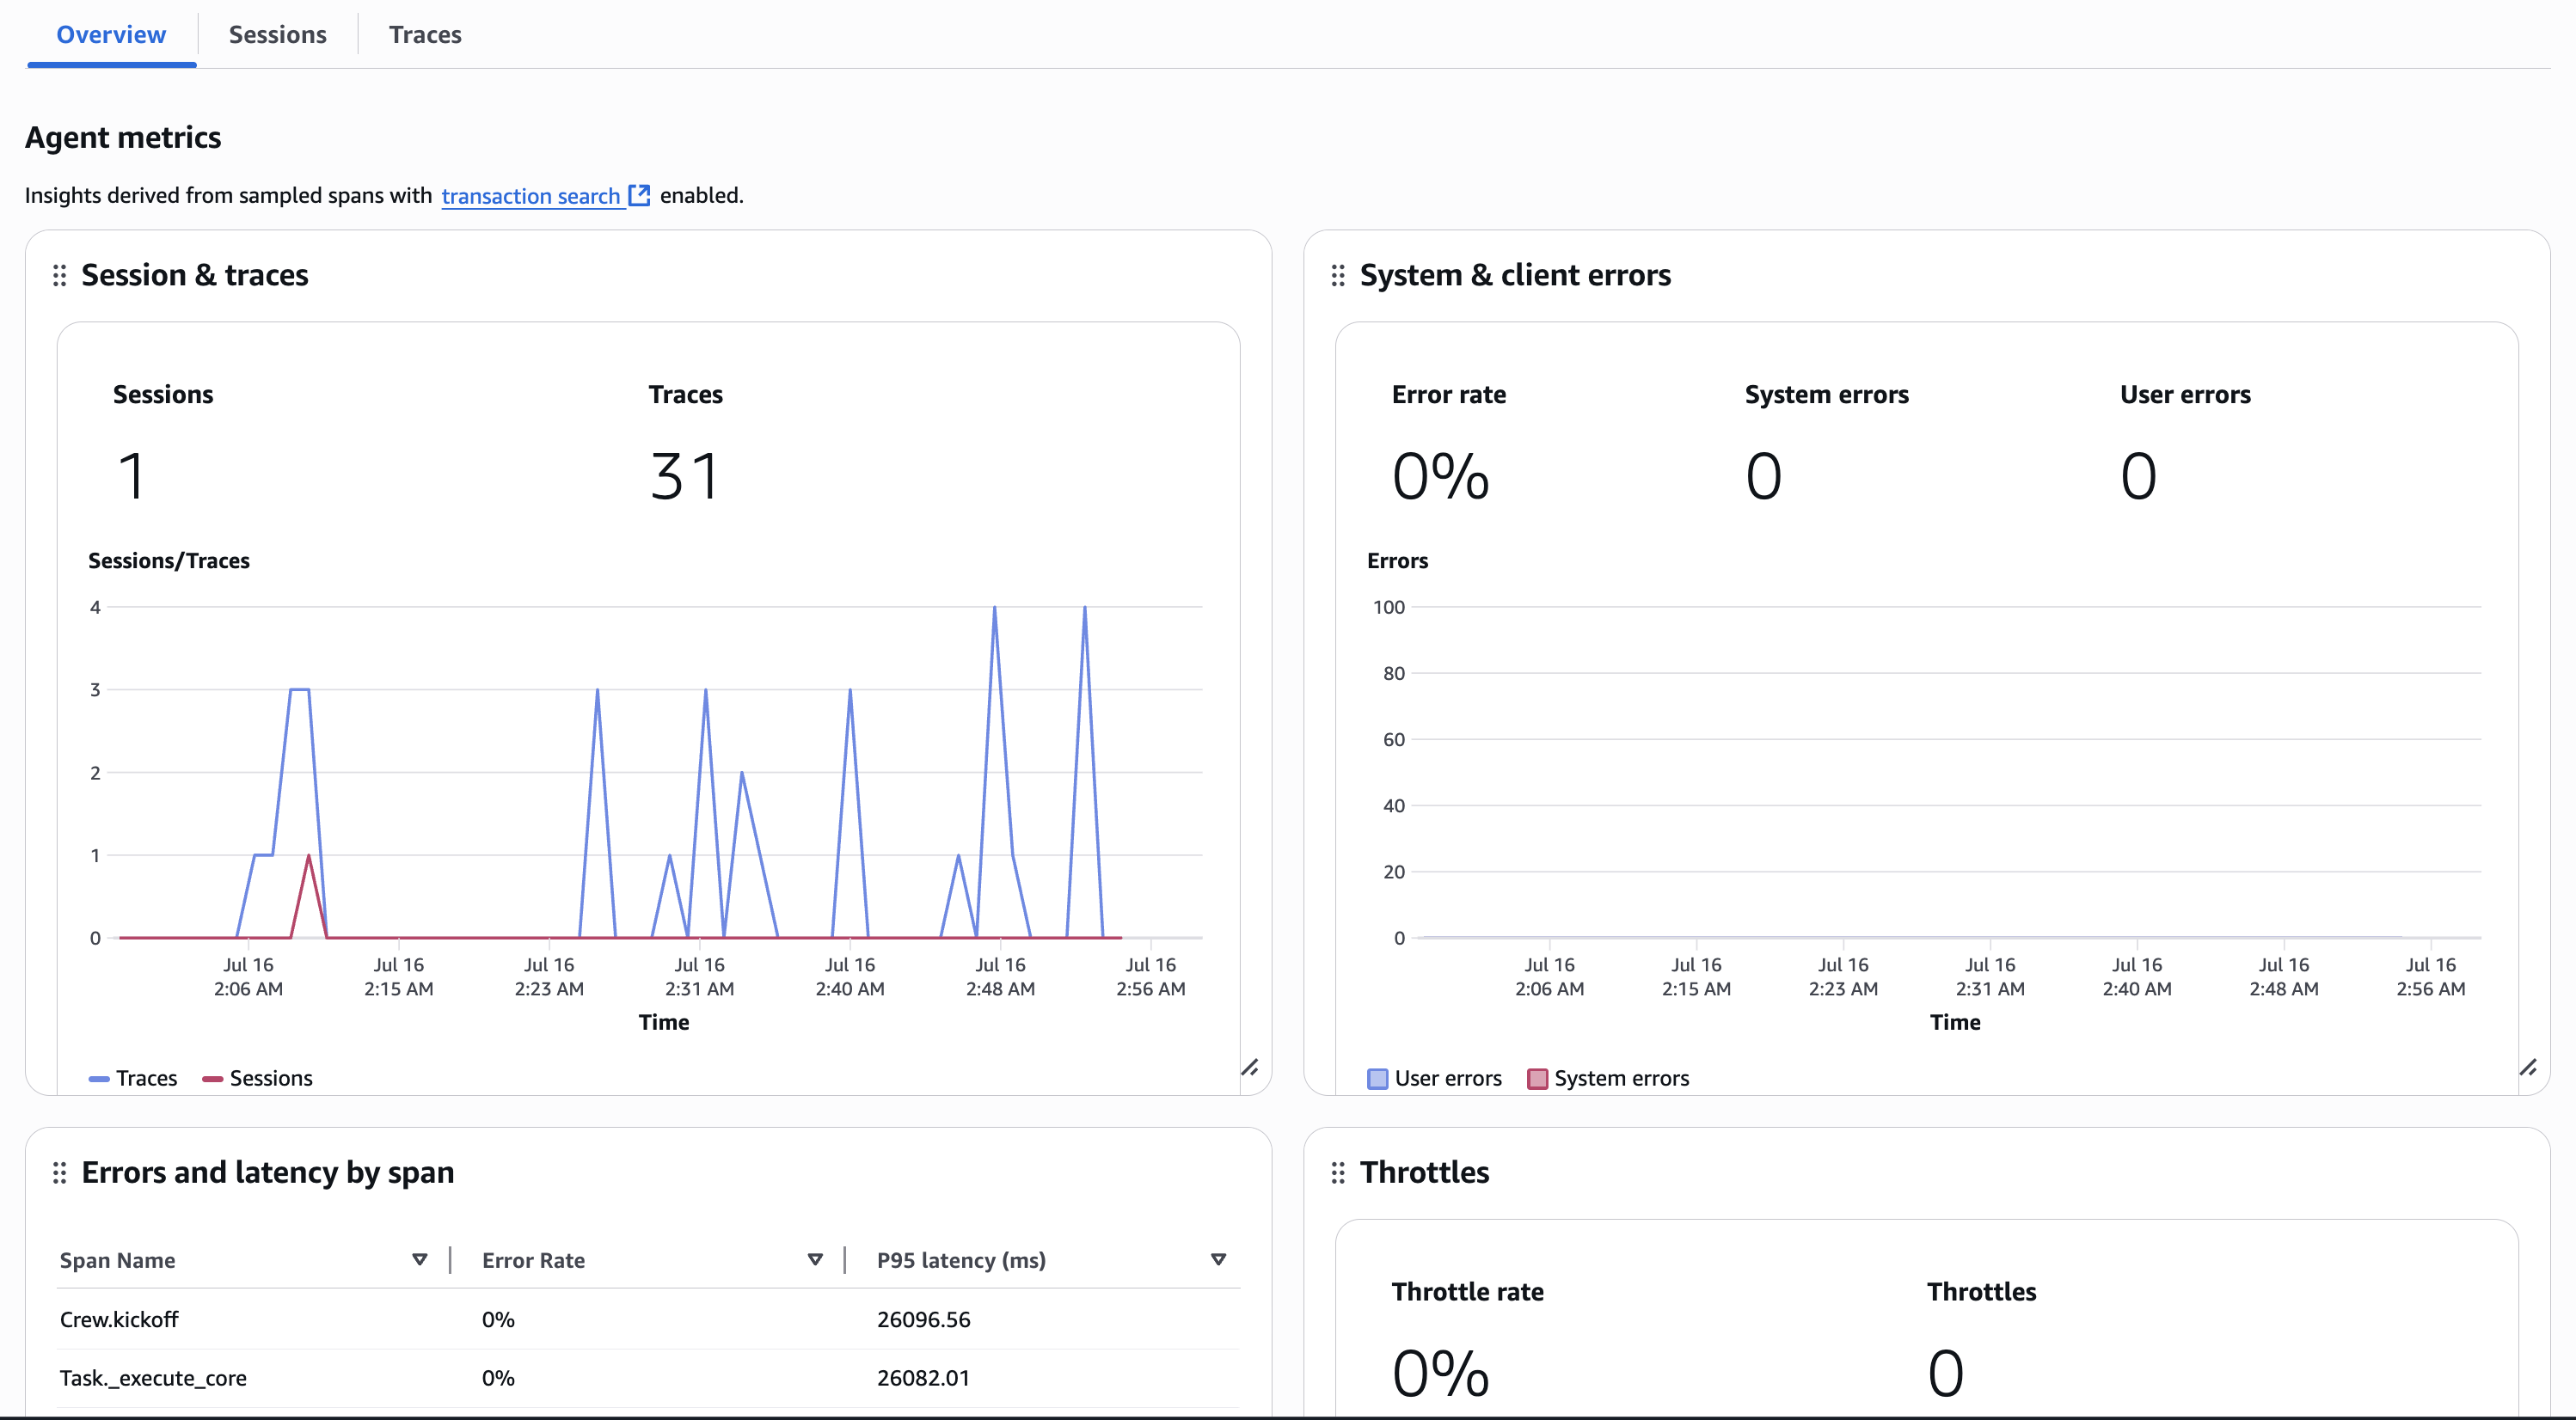

#### Trace View Page:
Trace View:
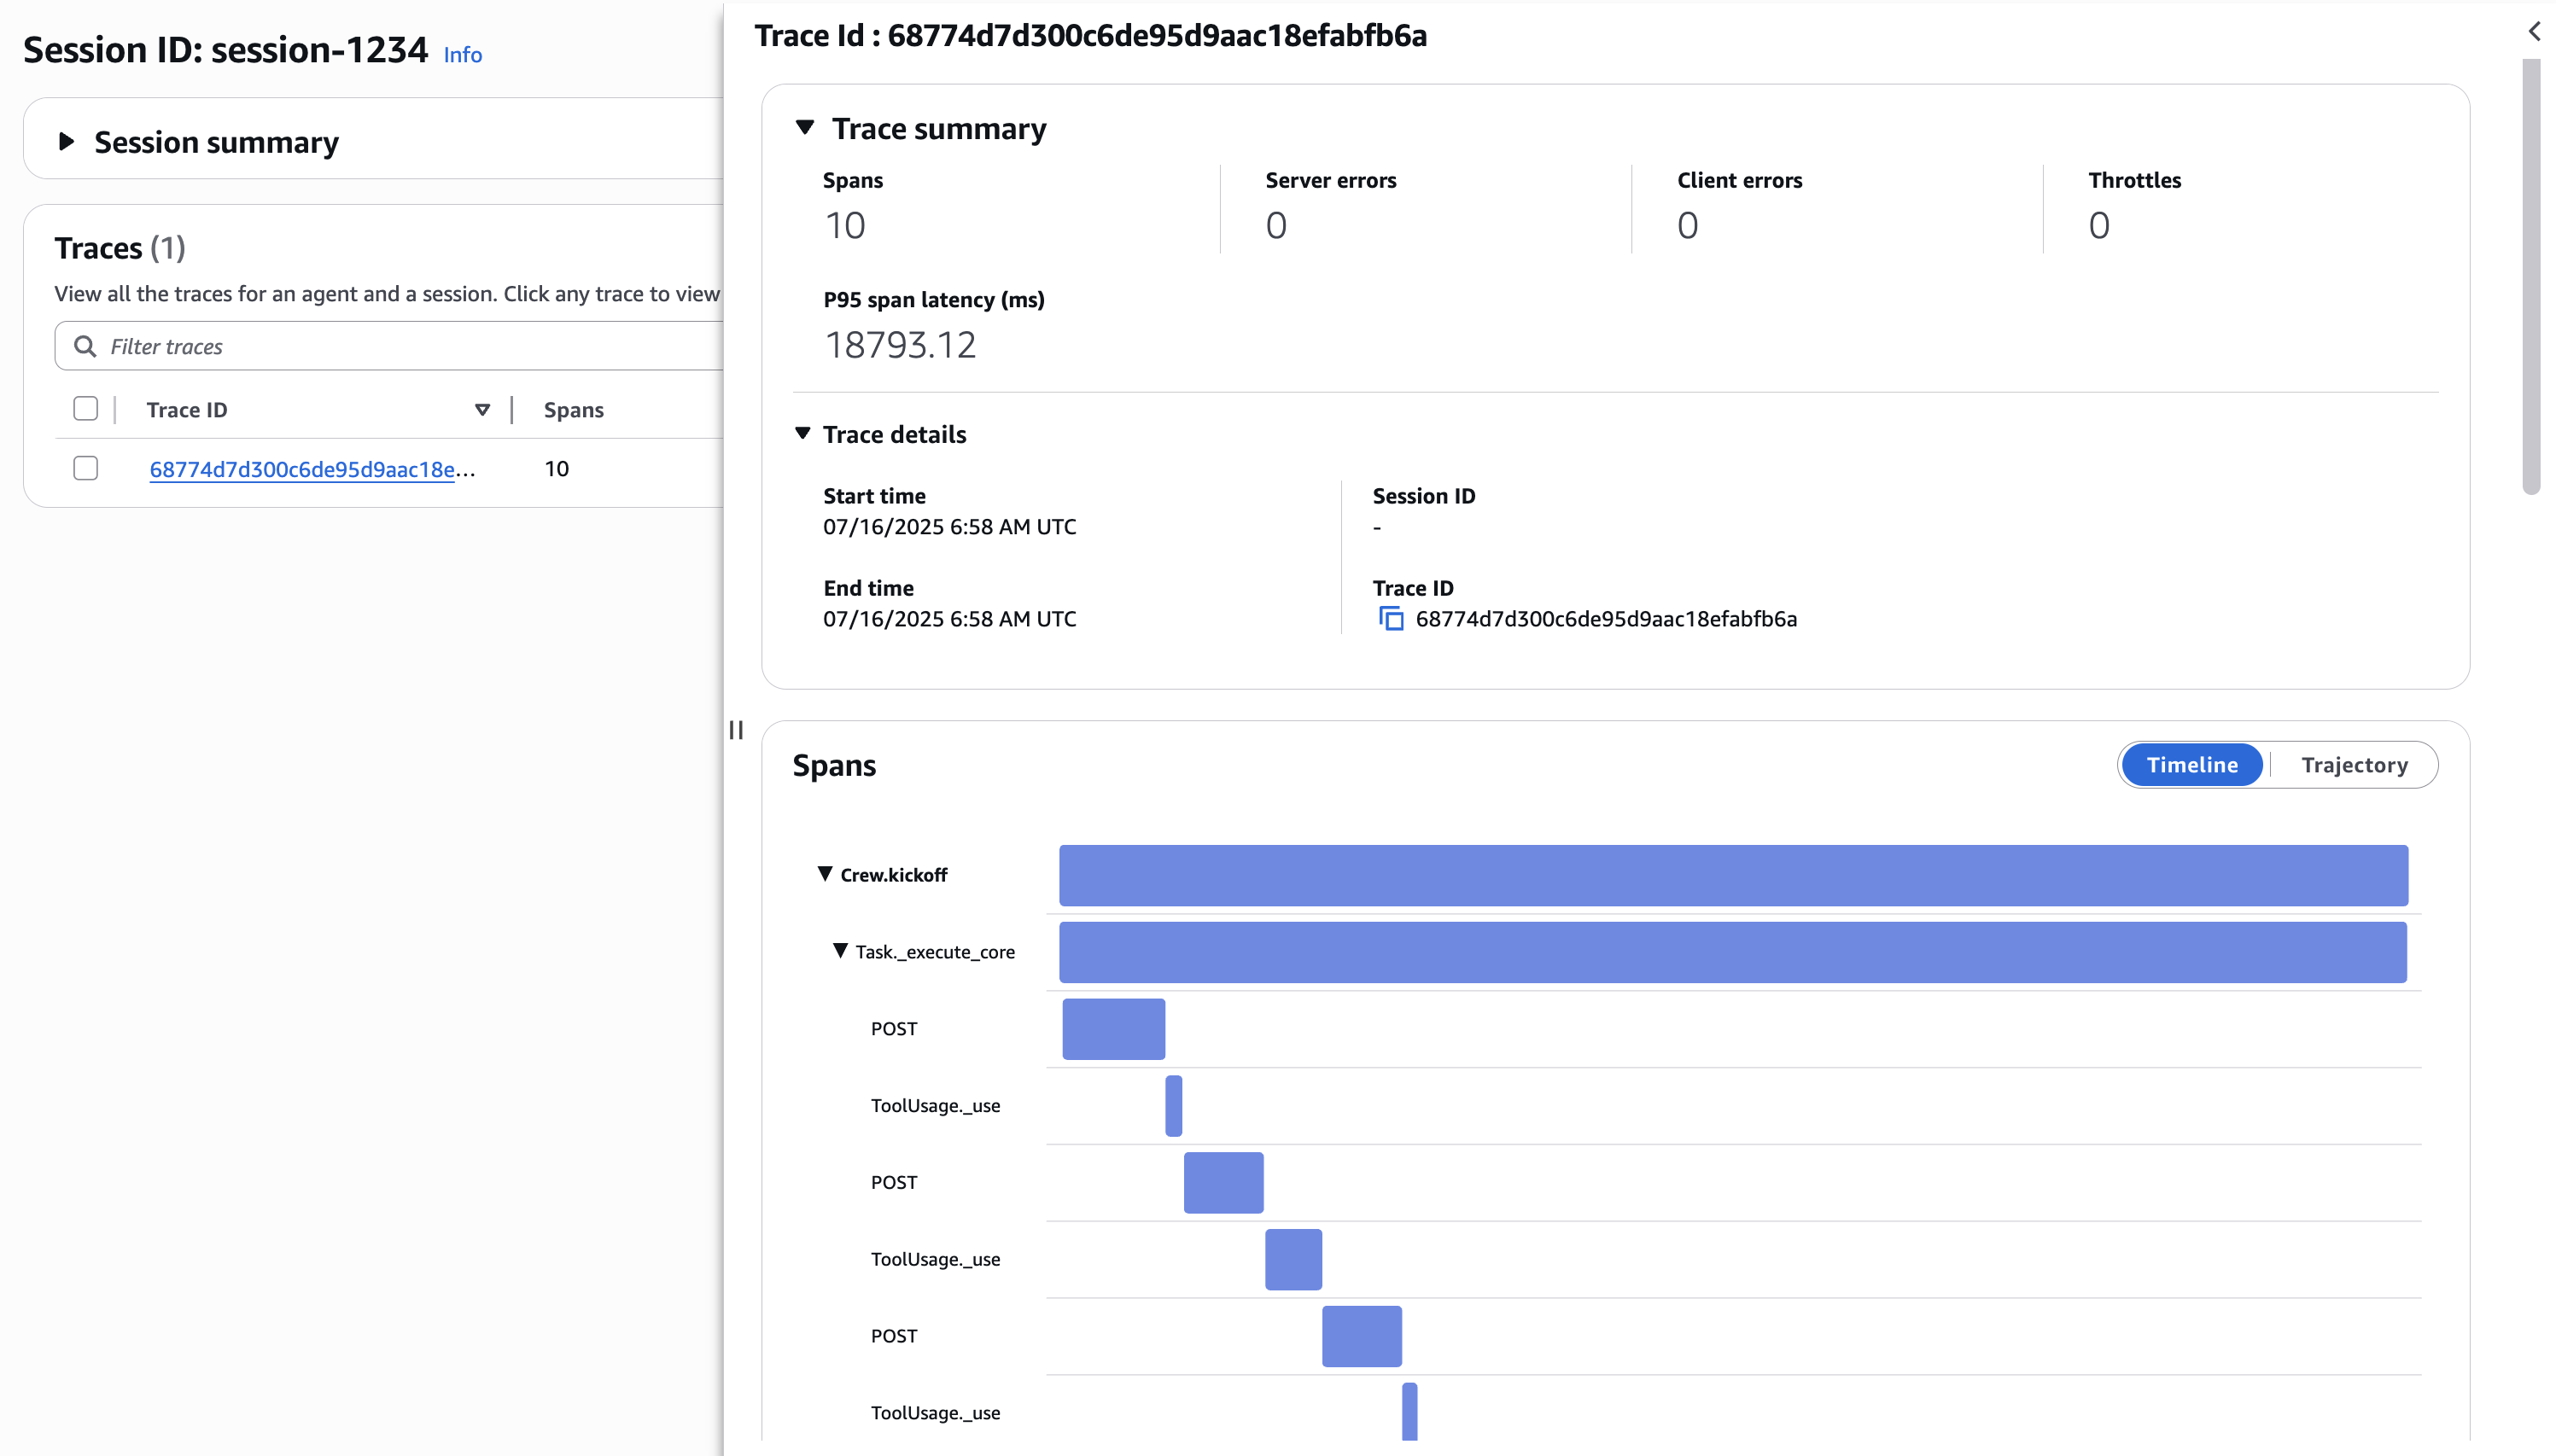

Trace details:
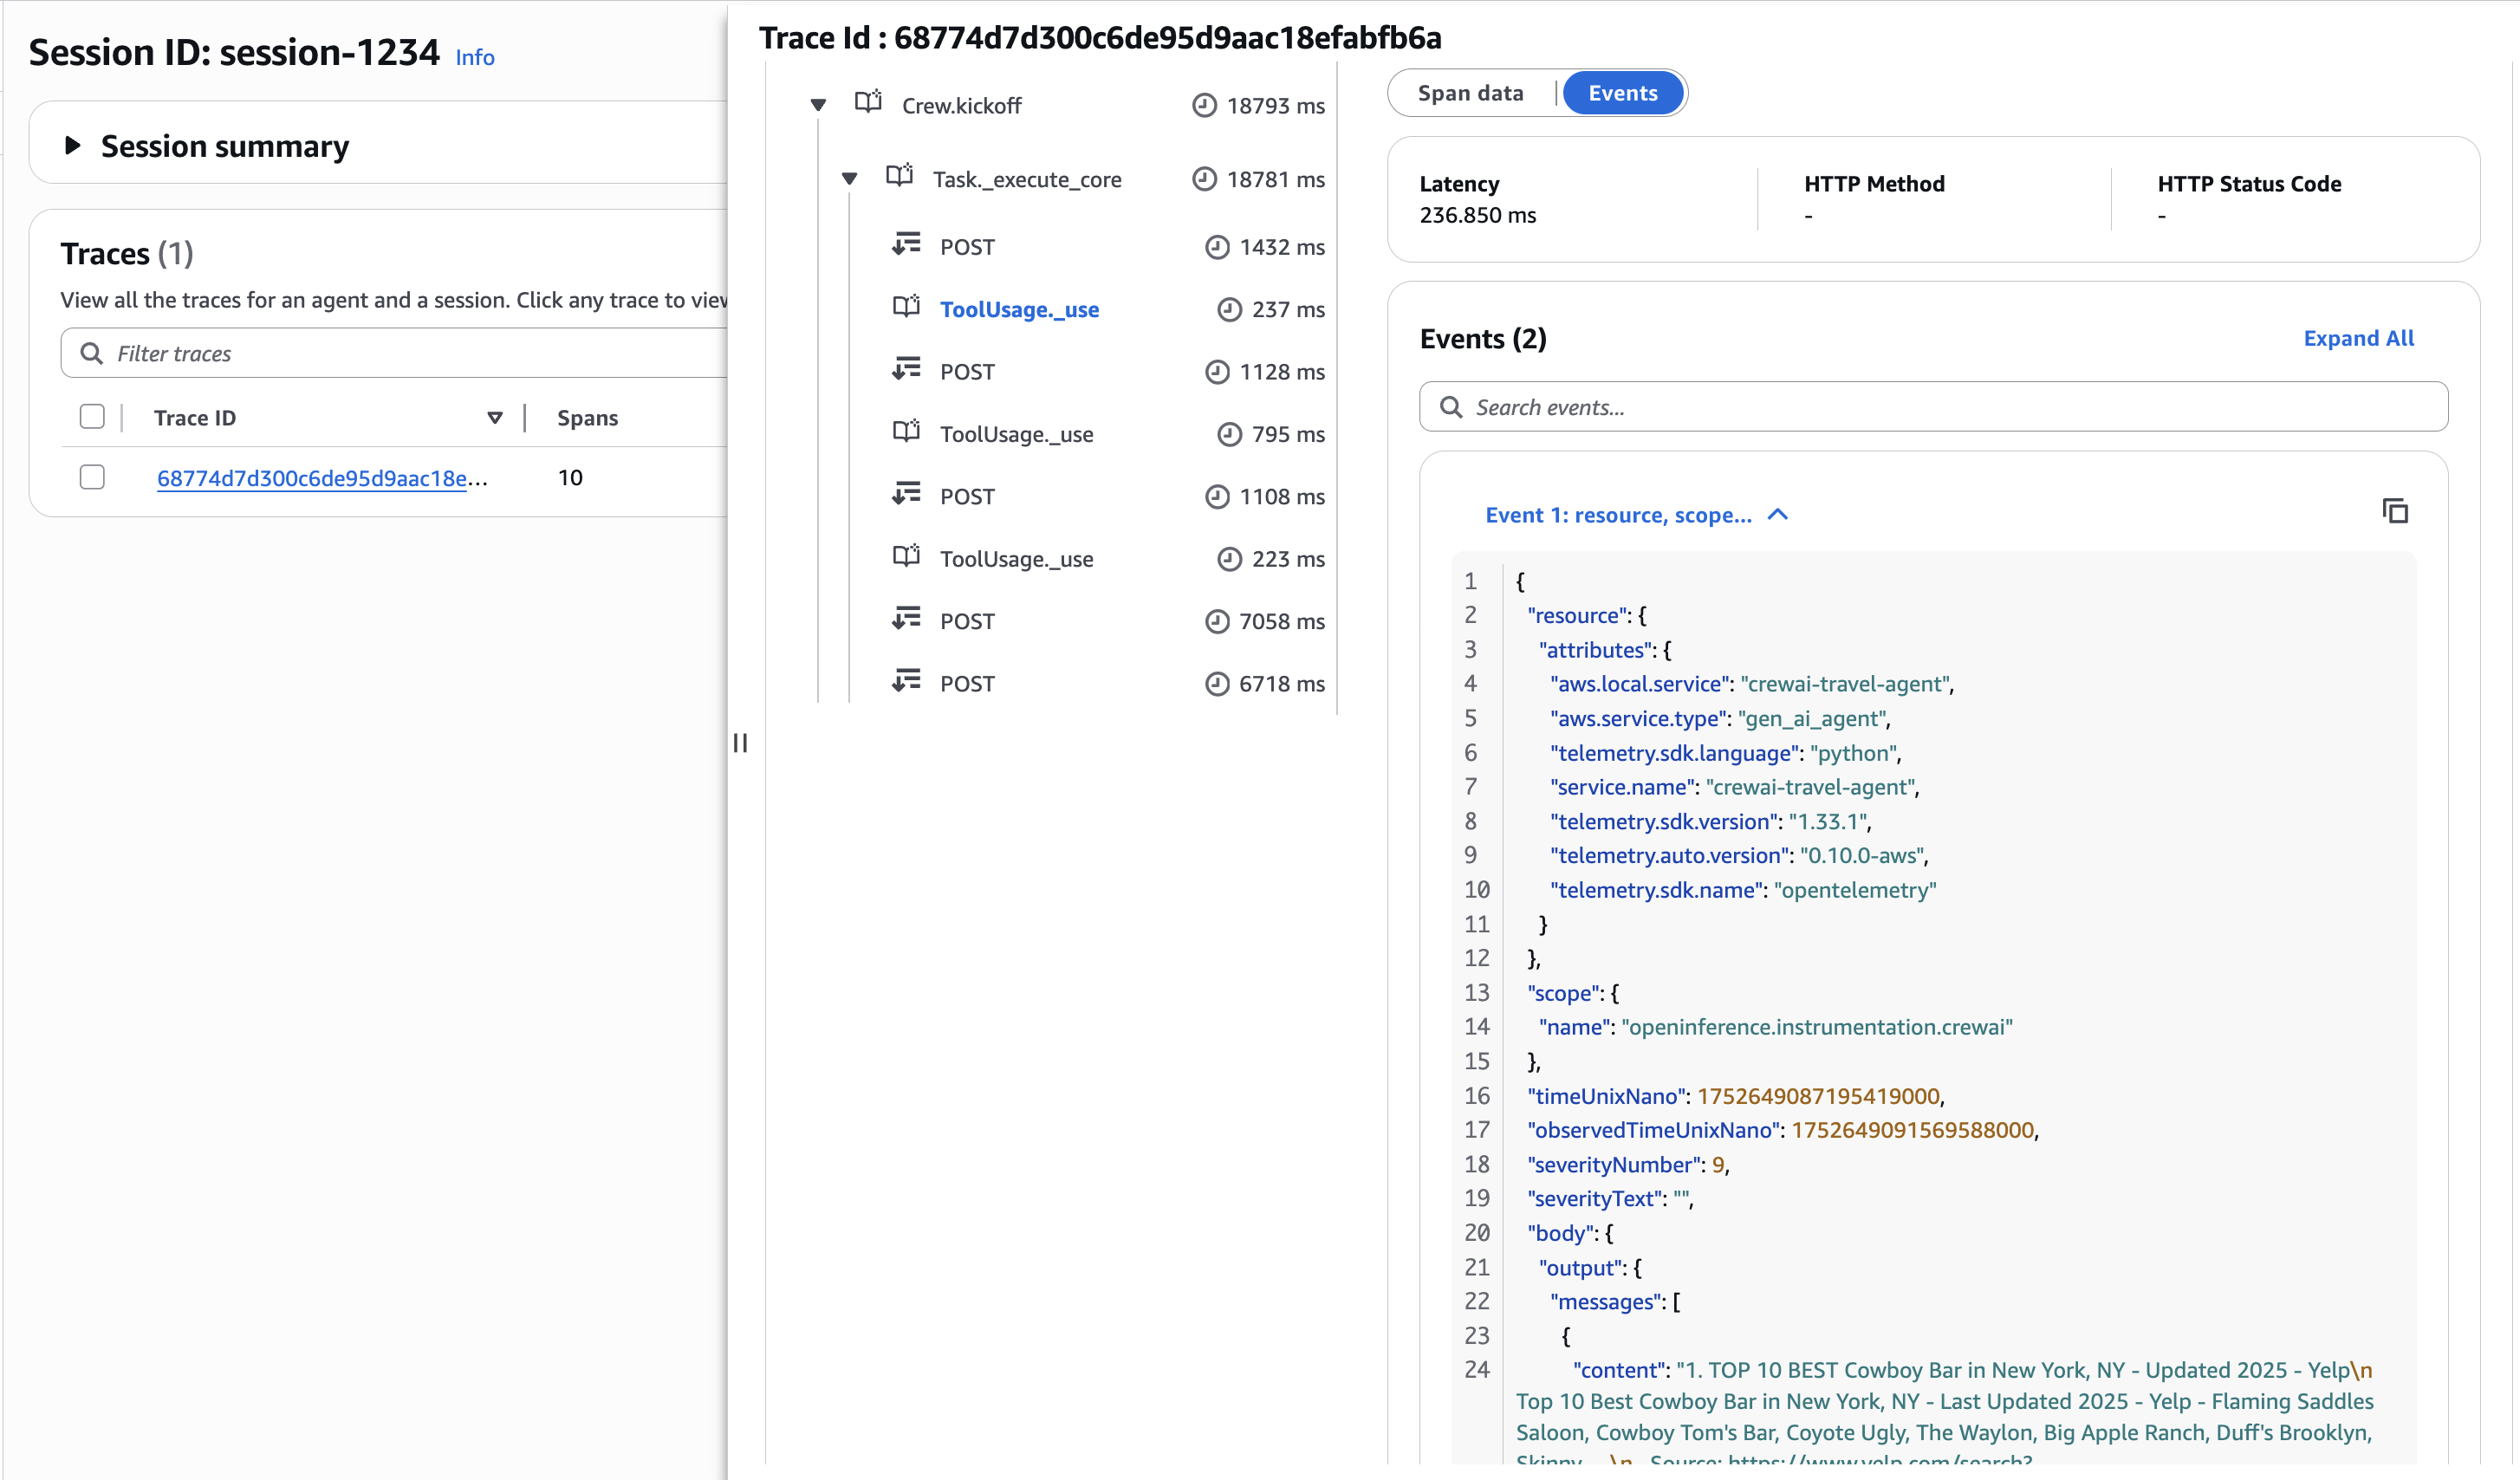


## 9. Troubleshooting

If you're not seeing traces in Amazon CloudWatch, check the following:

1. **AWS Credentials**: Ensure your AWS credentials are properly configured
2. **IAM Permissions**: Make sure your IAM user/role has permissions for Amazon CloudWatch
3. **Region and Log groups**: Confirm you're looking in the correct AWS region and Log groups
4. **Environment Variables**: Verify all OTEL_* environment variables are set correctly



## 10. Conclusion 

Congratulations you implemented and instrumented a Crew AI Open source Agent with Amazon Bedrock Model which has observability through Amazon CloudWatch. 

- CrewAI travel agent.
- Full OpenTelemetry tracing to AWS CloudWatch
- Traces and Logs for Amazon Bedrock calls, CrewAI operations, etc.


## 11. Next Steps

Now that you have CrewAI with OpenTelemetry set up, you can:

1. **Add More Agents**: Create a multi-agent crew with different roles
2. **Add Tools to your agent**: Integrate tools, API tools, or custom tools
3. **[Set Up Alarms](https://docs.aws.amazon.com/AmazonCloudWatch/latest/monitoring/AlarmThatSendsEmail.html)**: Create alarms on the metrics that are important to your business like `latency`, `token input`, and `token output` etc..
